<a href="https://colab.research.google.com/github/degenerate-kun-69/GamblingAssistGenshin/blob/main/Genshin_Impact_Gacha_Prediction_LSTM_Model_Multi_User_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genshin Impact 5★ Prediction Model
**Objective**: Predict probability of getting a 5★ character/weapon within next 10 pulls  
**Data Features**:  
- Multiple users (UIDs)  
- Temporal patterns  
- Pity counter mechanics

# 1. Environment Setup

In [ ]:
# Import dependencies
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

# Set random seeds for reproducibility
np.random.seed(69)
tf.random.set_seed(69)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to prevent TensorFlow from using all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Set TensorFlow to use the first available GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f"Using GPU: {gpus[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected, using CPU.")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 2. Data Loading & Preparation

In [ ]:
# Load data
data_path = Path("wishHistory2.xlsx")
data = pd.read_excel(data_path)
data.columns=["TYPE","YYYY","MM","DD","HR","MIN","SEC","RARITY","PITY","#ROLL","GRP","UID"]

In [ ]:
#Create a datetime column that has complete datetime info
data['DATETIME'] = data['YYYY'].astype(str) + '-' + data['MM'].astype(str).str.zfill(2) + '-' + data['DD'].astype(str).str.zfill(2) + ' ' + data['HR'].astype(str).str.zfill(2) + ':' + data['MIN'].astype(str).str.zfill(2) + ':' + data['SEC'].astype(str).str.zfill(2)

In [ ]:
#make the DATETIME column a datetime object
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

In [ ]:
# Sort by user and time
data = data.sort_values(['UID', 'DATETIME']).reset_index(drop=True)

# Convert banner type to binary
data['TYPE'] = data['TYPE'].map({'Character': 1, 'Weapon': 0})

In [ ]:
data.head()

,TYPE,YYYY,MM,DD,HR,MIN,SEC,RARITY,PITY,#ROLL,GRP,UID,DATETIME
0,0,2022,11,11,22,22,16,3,1,1,1,658320233,2022-11-11 22:22:16
1,0,2022,11,11,22,22,16,3,1,2,1,658320233,2022-11-11 22:22:16
2,0,2022,11,11,22,22,16,3,1,3,1,658320233,2022-11-11 22:22:16
3,0,2022,11,11,22,22,16,3,1,4,1,658320233,2022-11-11 22:22:16
4,0,2022,11,11,22,22,16,3,1,5,1,658320233,2022-11-11 22:22:16


# 3. Feature Engineering

## Version with roll, pity, grp and UID merged into a single feature to ensure no time series data leakage

In [ ]:
def create_features(df):
    """Feature engineering for a single user's data"""
    # Time-based features
    df['TIME_SINCE_LAST'] = df['DATETIME'].diff().dt.total_seconds().fillna(0)
    df['HOUR'] = df['DATETIME'].dt.hour
    df['DAY_OF_WEEK'] = df['DATETIME'].dt.dayofweek  # Monday=0
    df['MONTH'] = df['DATETIME'].dt.month

    # Compute Pity
    df['PITY'] = df['RARITY'].eq(5).cumsum().shift().fillna(0).astype(int)
    df['ROLL_COUNT'] = df.groupby('UID').cumcount() + 1
    df['PITY'] = df['ROLL_COUNT'] - df.groupby(['UID', df['PITY']]).cumcount()

    # Merge ROLL and GRP
    df['ROLL_GRP'] = df['ROLL_COUNT'] * 100 + df['GRP']

    # Merge ROLL_GRP and PITY
    df['ROLL_GRP_PITY'] = df['ROLL_GRP'] * 1000 + df['PITY']

    # Merge ROLL_GRP_PITY and UID
    df['ROLL_DATA'] = df['ROLL_GRP_PITY'] * 1000000 + df['UID']

    # Version flags
    df['POST_SUMERU'] = (df['DATETIME'] >= '2022-08-24').astype(int)

    # Create target: 5★ in next 10 rolls
    df['TARGET'] = 0
    for i in range(1, 11):
        df['TARGET'] |= (df['RARITY'].shift(-i) == 5).fillna(0).astype(int)

    # Remove incomplete sequences
    return df.iloc[:-10] if len(df) > 10 else df

# Apply to each user
data = data.groupby('UID', group_keys=False).apply(create_features)

# Cleanup
data = data.drop(columns=[
    'YYYY', 'MM', 'DD', 'HR', 'MIN', 'SEC',
    '#ROLL', 'GRP', 'RARITY', 'PITY', 'ROLL_COUNT', 'ROLL_GRP', 'ROLL_GRP_PITY', 'UID'
])


<ipython-input-8-c646c1946119>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('UID', group_keys=False).apply(create_features)


In [ ]:
data.head()

,TYPE,DATETIME,TIME_SINCE_LAST,HOUR,DAY_OF_WEEK,MONTH,ROLL_DATA,POST_SUMERU,TARGET
0,0,2022-11-11 22:22:16,0.0,22,4,11,101659320233,1,0
1,0,2022-11-11 22:22:16,0.0,22,4,11,201659320233,1,0
2,0,2022-11-11 22:22:16,0.0,22,4,11,301659320233,1,0
3,0,2022-11-11 22:22:16,0.0,22,4,11,401659320233,1,0
4,0,2022-11-11 22:22:16,0.0,22,4,11,501659320233,1,0


## Version without pity and UID merged into a single feature

In [ ]:
def create_features(df):
    """Feature engineering for a single user's data"""
    # Time-based features
    df['TIME_SINCE_LAST'] = df['DATETIME'].diff().dt.total_seconds().fillna(0)
    df['HOUR'] = df['DATETIME'].dt.hour
    df['DAY_OF_WEEK'] = df['DATETIME'].dt.dayofweek  # Monday=0
    df['MONTH'] = df['DATETIME'].dt.month

    # Version flags (adjust dates based on actual game updates)
    df['POST_SUMERU'] = (df['DATETIME'] >= '2022-08-24').astype(int)

    # Create target: 5★ in next 10 rolls
    df['TARGET'] = 0
    for i in range(1, 11):
        df['TARGET'] |= (df['RARITY'].shift(-i) == 5).fillna(0).astype(int)

    # Remove incomplete sequences
    return df.iloc[:-10] if len(df) > 10 else df

# Apply to each user
data = data.groupby('UID', group_keys=False).apply(create_features)

# Cleanup
data = data.drop(columns=[
    'YYYY', 'MM', 'DD', 'HR', 'MIN', 'SEC',
    '#ROLL', 'GRP', 'RARITY', 'DATETIME'
])

<ipython-input-4-9f8793bbeab1>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('UID', group_keys=False).apply(create_features)


In [ ]:
data.head()

,TYPE,PITY,UID,TIME_SINCE_LAST,HOUR,DAY_OF_WEEK,MONTH,POST_SUMERU,TARGET
0,0,1,658320233,0.0,22,4,11,1,0
1,0,1,658320233,0.0,22,4,11,1,0
2,0,1,658320233,0.0,22,4,11,1,0
3,0,1,658320233,0.0,22,4,11,1,0
4,0,1,658320233,0.0,22,4,11,1,0


In [ ]:
data['UID'].unique()

array([ 658320233,  722888193,  762905741,  811601496,  824151011,
        837923370,  856578893,  883244791, 1811453929])

In [ ]:
data['UID'].value_counts()

,count
UID,
658320233,3594
811601496,1496
824151011,1372
762905741,712
883244791,700
722888193,546
1811453929,327
856578893,188
837923370,134


In [ ]:
data['TARGET'].value_counts()

,count
TARGET,
0,7712
1,1357


# 4. Train-Test Split

## Version with pity and UID merged

In [ ]:
def temporal_split(df, test_size=0.3):
    split_idx = int(len(df) * (1 - test_size))
    return df.iloc[:split_idx], df.iloc[split_idx:]

In [ ]:
# sort by time before splitting because new feature engineered means no uid leakage
data=data.sort_values(by='DATETIME')

In [ ]:
#time based split
train, test = temporal_split(data)

## Version without pity and UID merged

In [ ]:
def temporal_split(df, test_size=0.3):
    split_idx = int(len(df) * (1 - test_size))
    return df.iloc[:split_idx], df.iloc[split_idx:]

# Split per user
train_parts, test_parts = [], []
for uid, uid_df in data.groupby('UID'):
    train_part, test_part = temporal_split(uid_df)
    train_parts.append(train_part)
    test_parts.append(test_part)

train = pd.concat(train_parts)
test = pd.concat(test_parts)

In [ ]:
train['UID'].value_counts()

,count
UID,
658320233,2515
811601496,1047
824151011,960
762905741,498
883244791,489
722888193,382
1811453929,228
856578893,131
837923370,93


In [ ]:
test['UID'].value_counts()

,count
UID,
658320233,1079
811601496,449
824151011,412
762905741,214
883244791,211
722888193,164
1811453929,99
856578893,57
837923370,41


In [ ]:
# Verify no user leakage
assert set(train['UID']).isdisjoint(set(test['UID'])), "User leakage detected!"

AssertionError: User leakage detected!

# 5. Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Feature selection (replace PITY with ROLL_DATA)
features = ['ROLL_DATA', 'TYPE', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'POST_SUMERU', 'TIME_SINCE_LAST']

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[features])
X_test = scaler.transform(test[features])
y_train = train['TARGET'].values
y_test = test['TARGET'].values


# 6. Sequence Generation

In [ ]:
def create_sequences(data, targets, lookback):
    """Create time-aware sequences without grouping by UID"""
    sequences = []
    final_targets = []

    for i in range(lookback, len(data)):
        sequences.append(data[i-lookback:i])
        final_targets.append(targets[i])

    return np.array(sequences), np.array(final_targets)

lookback = 75  # Based on Genshin's soft pity system
X_train_seq, y_train_seq = create_sequences(X_train, y_train, lookback)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, lookback)


Shift data to GPU for faster pipeline

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_seq, y_train_seq)).batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_seq, y_test_seq)).batch(64).prefetch(tf.data.AUTOTUNE)


# 7. LSTM Model Architecture + Training

## Single LSTM layer model

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(lookback, len(features)), recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,497 (72.25 KB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

Handle class imbalance

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_seq)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_seq)
class_weights = dict(zip(classes, weights))

In [ ]:
# Handle class imbalance
#class_weights = {0: 1, 1: 10}  # Adjust based on data distribution
"""
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)
"""
model.fit(train_ds, validation_data=test_ds, epochs=200, class_weight=class_weights)

Epoch 1/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.5569 - auc: 0.4788 - loss: 0.6968 - val_accuracy: 0.3031 - val_auc: 0.5312 - val_loss: 0.7357
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.2435 - auc: 0.5282 - loss: 0.6958 - val_accuracy: 0.4384 - val_auc: 0.5258 - val_loss: 0.7031
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.2289 - auc: 0.5137 - loss: 0.6946 - val_accuracy: 0.6138 - val_auc: 0.5267 - val_loss: 0.6865
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.2724 - auc: 0.5258 - loss: 0.6925 - val_accuracy: 0.6856 - val_auc: 0.5302 - val_loss: 0.6779
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.3183 - auc: 0.5114 - loss: 0.6932 - val_accuracy: 0.5608 - val_auc: 0.5255 - val_loss: 0.6953
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.2556 - auc: 0.5072 - loss: 0.6939 - val_accuracy: 0.6379 - val_auc: 0.5187 - val_loss: 0.6855
Epoch 7/200
99/99 ━━━━━━━━━━

## Stacked LSTM Model

In [ ]:
model = Sequential([
    LSTM(100, input_shape=(lookback, len(features)), return_sequences=True, recurrent_dropout=0.2),
    Dropout(0.2),
    LSTM(50, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(32,activation='relu'),
    Dropout(0,2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 75, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,065 (293.22 KB)

 Trainable params: 75,065 (293.22 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [ ]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.batch(64)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)


Handle class imbalance

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_seq)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_seq)
class_weights = dict(zip(classes, weights))


In [ ]:
# Handle class imbalance
#class_weights = {0: 1, 1: 10}  # Adjust based on data distribution
"""
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)
"""
model.fit(train_ds, validation_data=test_ds, epochs=200, class_weight=class_weights)

Epoch 1/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 47s 419ms/step - accuracy: 0.1732 - auc: 0.4864 - loss: 1.6042 - val_accuracy: 0.1432 - val_auc: 0.5343 - val_loss: 0.9292
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 81s 406ms/step - accuracy: 0.1592 - auc: 0.4937 - loss: 1.5814 - val_accuracy: 0.1432 - val_auc: 0.5227 - val_loss: 0.9634
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 0.1592 - auc: 0.5128 - loss: 1.5742 - val_accuracy: 0.1432 - val_auc: 0.5137 - val_loss: 0.9749
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 90s 512ms/step - accuracy: 0.1592 - auc: 0.5092 - loss: 1.5761 - val_accuracy: 0.1432 - val_auc: 0.5080 - val_loss: 0.9386
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 46s 463ms/step - accuracy: 0.1593 - auc: 0.5061 - loss: 1.5762 - val_accuracy: 0.1432 - val_auc: 0.4790 - val_loss: 0.9662
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 80s 447ms/step - accuracy: 0.1613 - auc: 0.5206 - loss: 1.5753 - val_accuracy: 0.1432 - val_auc: 0.5067 - val_loss: 0.9733
Epoch 7/200
99/99 ━━━━━━━━━━

KeyboardInterrupt: 

## Bidirectional LSTM Model

In [ ]:
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.2), input_shape=(lookback, len(features))),
    Dropout(0.3),
    LSTM(50, recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


Handle class imbalance

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_seq)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_seq)
class_weights = dict(zip(classes, weights))


Train the model

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=200, class_weight=class_weights)

# 8. Performance Visualization

NameError: name 'history' is not defined

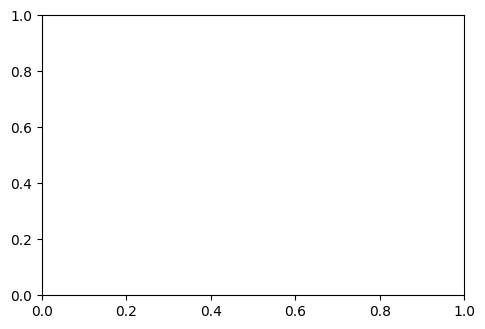

In [ ]:
# Plot training history
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Progress')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Progress')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Progress')
plt.legend()

plt.tight_layout()
plt.show()

# 9. Model Validation Checks

In [ ]:
# Verify pity counter resets
def verify_pity_resets(df):
    for uid, uid_df in df.groupby('UID'):
        resets = uid_df['PITY'].diff() < 0
        assert sum(resets) == sum(uid_df['TARGET'] == 1), \
            f"Pity reset mismatch for UID {uid}"
    print("All pity counters reset correctly!")

verify_pity_resets(train)
verify_pity_resets(test)

KeyError: 'UID'

# 10. Model Export

In [ ]:
# Save model and scaler
model.save('genshin_gacha_predictor.keras')
import joblib
joblib.dump(scaler, 'scaler.gz')